# Uniswap v3 liquidity analysis

In this notebook we will show how to download liquidity events from Uniswap V3 to your computer as CSV files and use them to construct and analyse liquidity in each pool.

* For more background information, see [this blog post about the topic](https://tradingstrategy.ai/blog/uniswap-data-research-with-jupyter-and-python)

* You need to understand [Jupyter Notebook and Pandas basics](https://jakevdp.github.io/PythonDataScienceHandbook/)

* You need to understand [Ethereum](https://github.com/ethereumbook/ethereumbook) and [Web3.py basics](https://web3py.readthedocs.io/)

* You will need to have [Ethereum API node and its JSON-RPC URL](https://ethereumnodes.com/) in order to pull out the data from Ethereum blockchain. The notebook will interactively ask you for your API key.

* You can click *Launch binder* button on this documentation page to automatically open this notebook to be run in
  [Binder cloud notebook service](https://mybinder.org/). Note that we recommend to run the notebook
  on your local computer, as generated CSV needs are large and take long time to generate.

### Download the raw data from Ethereum blockchain

For simplicity, you can sign up for free access to an Ethereum node for example at [Infura](https://infura.io/), however we recommend you to [run your own Ethereum node](https://tradingstrategy.ai/blog/preparing-a-server-for-hosting-goethereum-full-node)

In [1]:
from web3 import Web3, HTTPProvider

# Get your node JSON-RPC URL
json_rpc_url = input("Please enter your Ethereum mainnet JSON-RPC URL here")
web3 = Web3(HTTPProvider(json_rpc_url))

As an example, here we download raw liquidity events from first 100000 blocks after Uniswap V3 factory is created, the events will be stored in several CSV files at `/tmp` folder.

Depends on your internet connection and latency to the Ethereum node, the scan might take hours. However it can resume in case there is a crash, as we save the last scanned block in a JSON state file.

In [39]:
from eth_defi.uniswap_v3.constants import UNISWAP_V3_FACTORY_CREATED_AT_BLOCK
from eth_defi.uniswap_v3.events import fetch_events_to_csv
from eth_defi.event_reader.json_state import JSONFileScanState

start_block = UNISWAP_V3_FACTORY_CREATED_AT_BLOCK
end_block = UNISWAP_V3_FACTORY_CREATED_AT_BLOCK + 100_000

# Stores the last block number of event data we store
state = JSONFileScanState("/tmp/uniswap-v3-liquidity-scan.json")

fetch_events_to_csv(json_rpc_url, state, start_block=start_block, end_block=end_block)

No previous scan done, starting fresh from block 12,369,621, total 100,000 blocks
Scanning block range 12,369,621 - 12,469,621


  0%|          | 0/100000 [00:00<?, ?it/s]

Wrote 1113 PoolCreated events
Wrote 461356 Swap events
Wrote 20791 Mint events
Wrote 9791 Burn events


### Construct intermediate data

A single raw liquidity event only tells us what happened to specific ticks in a specific pool. To be able to know how much liquidity is in each tick, we first need to construct intermediate data (we call them tick delta events) based on mint and burn events 

In [40]:
from eth_defi.uniswap_v3.liquidity import create_tick_delta_csv

tick_delta_csv = create_tick_delta_csv("/tmp/uniswap-v3-mint.csv", "/tmp/uniswap-v3-burn.csv")

Then we can use these delta events to aggregate into each tick liquidity 

In [41]:
from eth_defi.uniswap_v3.liquidity import create_tick_csv

tick_csv = create_tick_csv(tick_delta_csv)

Create a dataframe we can use for further analysis

In [42]:
import pandas as pd

tick_df = pd.read_csv(tick_csv)
tick_df

,Unnamed: 0,pool_contract_address,tick_id,liquidity_gross_delta,liquidity_net_delta
0,0,0x000ea4a83acefdd62b1b43e9ccc281f442651520,-82140,2060173899059917749827,2060173899059917749827
1,1,0x000ea4a83acefdd62b1b43e9ccc281f442651520,-82080,5508168315607950206,5508168315607950206
2,2,0x000ea4a83acefdd62b1b43e9ccc281f442651520,-82020,2060173899059917749827,-2060173899059917749827
3,3,0x000ea4a83acefdd62b1b43e9ccc281f442651520,-81960,5508168315607950206,-5508168315607950206
4,4,0x00323a300261042dd5d697e3f92a06279cc7d15b,62150,81896317601094011387162,81896317601094011387162
...,...,...,...,...,...
13645,13645,0xff90fb880da9738b2044b243daf8172bfe413b5c,-123120,0,0
13646,13646,0xff90fb880da9738b2044b243daf8172bfe413b5c,-122040,349127115575225137449,349127115575225137449
13647,13647,0xff90fb880da9738b2044b243daf8172bfe413b5c,-115140,0,0
13648,13648,0xff90fb880da9738b2044b243daf8172bfe413b5c,-111060,349127115575225137449,-349127115575225137449


### Liquidity analysis example

Choose a random pool from the tick dataframe, for example: UNI/ETH 0.3%

In [43]:
pool_address = "0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801"

Extract only the ticks relate to the pool we chose from the dataframe

In [44]:
df = tick_df[tick_df.pool_contract_address == pool_address].sort_values(by="tick_id")
df.index = df.tick_id

df

,Unnamed: 0,pool_contract_address,tick_id,liquidity_gross_delta,liquidity_net_delta
tick_id,,,,,
-345420,1352,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,-345420,0,0
-253260,1353,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,-253260,9540245628022539790,9540245628022539790
-242640,1354,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,-242640,2032338076661281779,2032338076661281779
-207240,1355,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,-207240,911269521453131094,911269521453131094
-206220,1356,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,-206220,1409245106840294,1409245106840294
...,...,...,...,...,...
99060,1881,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,99060,0,0
115140,1882,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,115140,1077028788640831727,-1077028788640831727
131220,1883,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,131220,10666729901899493,-10666729901899493


We then can plot the liquidity gross in this pool

<AxesSubplot:xlabel='tick_id'>

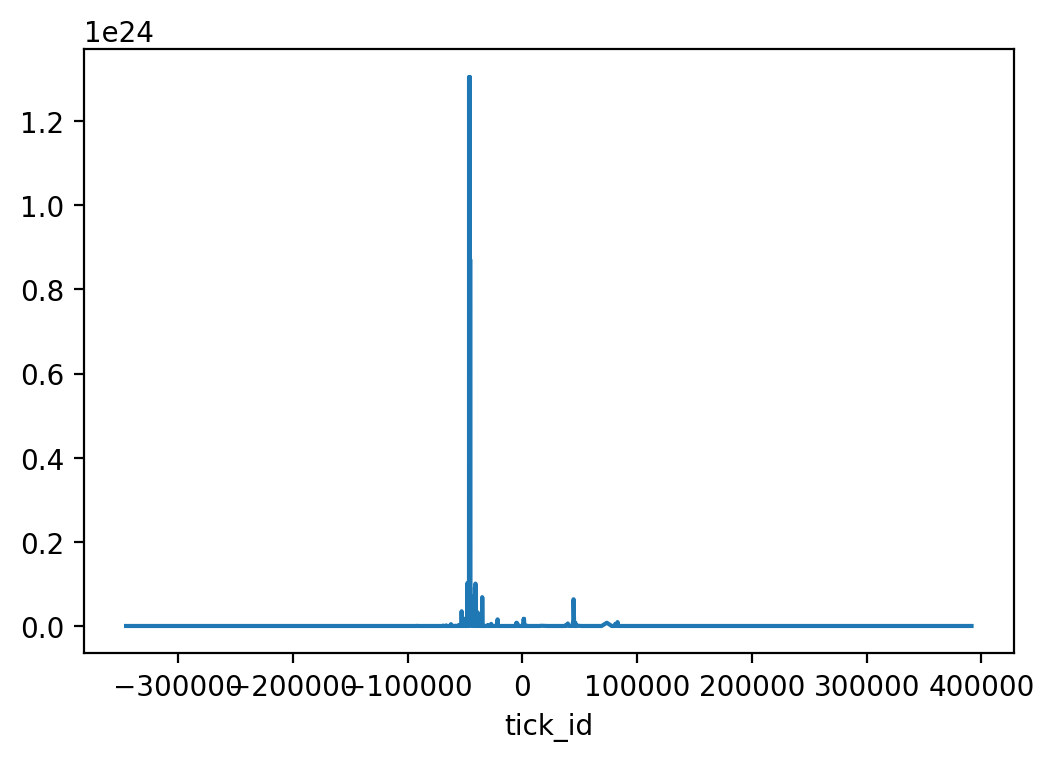

In [45]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

df["liquidity_gross_delta"].astype(float).plot()

### Compare the data with The Graph data

One way to verify whether the data we construct is correct is to compare it with official [Uniswap V3 subgraph data](https://thegraph.com/hosted-service/subgraph/uniswap/uniswap-v3)  

In [46]:
tickdelta_df = pd.read_csv(tick_delta_csv)
last_processed_block = tickdelta_df[tickdelta_df.pool_contract_address == pool_address].tail(1).block_number
last_processed_block = int(last_processed_block.values[0])
last_processed_block

12469604

Get pool's state at the same last processed block

In [47]:
from eth_defi.uniswap_v3.liquidity import get_pool_state_at_block

pool_state = get_pool_state_at_block(pool_address, last_processed_block)
ticks = pool_state["ticks"]

Then compare random ticks between our CSV data and the subgraph data

In [53]:
import random

# get some random ticks from subgraph
for i in range(10):
    random_tick = random.choice(ticks)

    # get the same tick from dataframe
    random_tick_df = df[df.tick_id == int(random_tick["tickIdx"])]
    
    # compare data
    assert int(random_tick_df.liquidity_gross_delta.values[0]) == int(random_tick["liquidityGross"])
    assert int(random_tick_df.liquidity_net_delta.values[0]) == int(random_tick["liquidityNet"])